In [1]:
# Insert code here.
import numpy as np
import torch
import torch.optim as optim
from torch.autograd import grad
from torch.autograd import Variable
import matplotlib.pyplot as plt
import time
import copy
from scipy.integrate import odeint
dtype=torch.float

%matplotlib inline


In [2]:
# for the plots
plt.rc('xtick', labelsize=16) 
plt.rcParams.update({'font.size': 16})

# Define the sin() activation function
class mySin(torch.nn.Module):
    @staticmethod
    def forward(input):
        return torch.sin(input)

In [3]:
# Define some more general functions
def dfx(x,f):
    # Calculate the derivative with auto-differention
    return grad([f], [x], grad_outputs=torch.ones(x.shape, dtype=dtype), create_graph=True)[0]

def perturbPoints(grid,t0,tf,sig=0.5):
#   stochastic perturbation of the evaluation points
#   force t[0]=t0  & force points to be in the t-interval
    delta_t = grid[1] - grid[0]  
    noise = delta_t * torch.randn_like(grid)*sig
    t = grid + noise
    t.data[2] = torch.ones(1,1)*(-1)
    t.data[t<t0]=t0 - t.data[t<t0]
    t.data[t>tf]=2*tf - t.data[t>tf]
    t.data[0] = torch.ones(1,1)*t0

    t.data[-1] = torch.ones(1,1)*tf
    t.requires_grad = False
    return t

In [4]:
def parametricSolutions(t, nn, t0, x1):
    # parametric solutions 
    N1,N2 = nn(t)
    dt =t-t0
#### THERE ARE TWO PARAMETRIC SOLUTIONS. Uncomment f=dt 
    f = (1-torch.exp(-dt))*(1-torch.exp(dt-12))
#     f=dt
    psi_hat  = x1  + f*N1
    return psi_hat


def hamEqs_Loss(t,psi, E,V):

    psi_dx = dfx(t,psi)
    psi_ddx= dfx(t,psi_dx)
    f = psi_ddx/2 + (E-V)*psi
    L  = (f.pow(2)).mean(); 
    return L

In [5]:
class qNN1(torch.nn.Module):
    def __init__(self, D_hid=10):
        super(qNN1,self).__init__()

        # Define the Activation
        #  self.actF = torch.nn.Sigmoid()   
        self.actF = mySin()
        
        # define layers
        #self.Lin_1   = torch.nn.Linear(1, D_hid)
        #self.E_out = torch.nn.Linear(D_hid, 1)
        #self.Lin_2 = torch.nn.Linear(D_hid, D_hid)
        #self.Ein = torch.nn.Linear(1,1)
        #self.Lin_out = torch.nn.Linear(D_hid+1, 1)
        
        self.Ein    = torch.nn.Linear(1,1)
        self.Lin_1  = torch.nn.Linear(2, D_hid)
        self.Lin_2  = torch.nn.Linear(D_hid, D_hid)
        self.out    = torch.nn.Linear(D_hid, 1)

    def forward(self,t):
        In1 = self.Ein(torch.ones_like(t))
        L1 = self.Lin_1(torch.cat((t,In1),1))
        h1 = self.actF(L1)
        L2 = self.Lin_2(h1)
        h2 = self.actF(L2)
        out = self.out(h2)
        return out, In1

In [6]:
def potential(Xs):
  # Gives the potential at each point
  # Takes in tensor of x points, gives back tensor of V at each point
  V = 40
  L = 1

  Xsnp = Xs.data.numpy()
  Vnp = (np.heaviside(-1*Xsnp-L/2, 0) + np.heaviside(Xsnp-L/2, 0))*V
  Vtorch = torch.from_numpy(Vnp)
  return Vtorch



In [7]:
# Train the NN
def run_Scan_finitewell(t0, tf, x1, neurons, epochs, n_train,lr, minibatch_number = 1):
    fc0 = qNN1(neurons)
    fc1=0; 
    betas = [0.999, 0.9999]
    optimizer = optim.Adam(fc0.parameters(), lr=lr, betas=betas)
    Loss_history = [];     Llim =  1e+20
    En_loss_history = []
    boundary_loss_history = []
    nontriv_loss_history = []
    SE_loss_history = []
    Ennontriv_loss_history = []
    criteria_loss_history = []
    En_history = []
    EWall_history = []
    di = (None, 1e+20)
    dic = {0:di, 1:di, 2:di, 3:di, 4:di, 5:di, 6:di, 7:di, 8:di, 9:di, 10:di}
    
    grid = torch.linspace(t0, tf, n_train).reshape(-1,1)
    
    ## TRAINING ITERATION    
    TeP0 = time.time()
    walle = -4
    last_psi_L = 0
    for tt in range(epochs): 
        #adjusting learning rate at epoch 3e4
        #if tt == 3e4:
        #    optimizer = optim.Adam(fc0.parameters(), lr = 1e-2, betas = betas)
# Perturbing the evaluation points & forcing t[0]=t0
        t=perturbPoints(grid,t0,tf,sig=.03*tf)
            
# BATCHING
        batch_size = int(n_train/minibatch_number)
        batch_start, batch_end = 0, batch_size

        idx = np.random.permutation(n_train)
        t_b = t[idx]
        t_b.requires_grad = True
        t_f=t[-1]
        t_f=t_f.reshape(-1,1)
        t_f.requires_grad = True
        loss=0.0


        for nbatch in range(minibatch_number): 
# batch time set
            t_mb = t_b[batch_start:batch_end]

#  Network solutions 
            nn, En = fc0(t_mb)

            En_history.append(En[0].data.tolist()[0])

            psi  = parametricSolutions(t_mb, fc0, t0, x1) 
            Pot = potential(t_mb)
            Ltot = hamEqs_Loss(t_mb, psi, En, Pot)
            SE_loss_history.append(Ltot) #
            criteria_loss = Ltot

            if tt%2600 == 0:
              walle += 1
            Ltot += 1/((psi.pow(2)).mean()+1e-6) + 1/(En.pow(2).mean()+1e-6) + torch.exp(-1*En+walle).mean()
            En_loss_history.append(torch.exp(-1*En+walle).mean()) #
            EWall_history.append(walle)
            
            nontriv_loss_history.append(1/((psi.pow(2)).mean()+1e-6)) #
            Ennontriv_loss_history.append(1/(En.pow(2).mean()+1e-6)) #
# OPTIMIZER
            Ltot.backward(retain_graph=False); #True
            optimizer.step(); loss += Ltot.data.numpy()
            optimizer.zero_grad()

            batch_start +=batch_size
            batch_end +=batch_size

# keep the loss function history
        Loss_history.append(loss)       

#Keep the best model (lowest loss) by using a deep copy
        if  criteria_loss < Llim:
            fc1 =  copy.deepcopy(fc0)
            Llim=criteria_loss

        E_bin = abs(En[0].data.tolist()[0]//10) 
        if criteria_loss < dic[E_bin][1]:
          dic[E_bin] = (copy.deepcopy(fc0), criteria_loss)

    TePf = time.time()
    runTime = TePf - TeP0  
    loss_histories = (Loss_history, boundary_loss_history, nontriv_loss_history, SE_loss_history, Ennontriv_loss_history, En_loss_history, criteria_loss_history, fc0, En_history, EWall_history, dic)
    return fc1, loss_histories, runTime

In [8]:
## Train the model 

t0 = -6.
tf = 6.
xBC1=0.

n_train, neurons, epochs, lr,mb = 1200, 50, int(85e3), 8e-3, 1 
model1,loss_hists1,runTime1 = run_Scan_finitewell(t0, tf, xBC1, neurons, epochs, n_train, lr, mb)

In [ ]:
aarg = np.argmin(loss_hists1[6])

ValueError: ignored

In [10]:
import pickle

In [11]:
from google.colab import drive
drive.mount('/content/gdrive')
imgdir = '/content/gdrive/My Drive/Harvard IACS Research/Plotting Data/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [12]:
pickle.dump((model1,loss_hists1,runTime1),open(imgdir+'fin_plot_data.sav','wb'))

Training time (minutes): 16.371424051125846


Text(0.5, 24.3, 'Epochs')

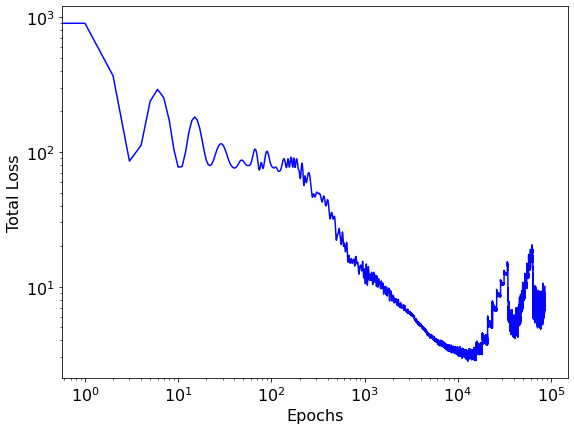

In [9]:
# Loss function
print('Training time (minutes):', runTime1/60)
plt.figure(figsize = (8,6))
plt.loglog(loss_hists1[0],'-b',alpha=0.975);
#plt.axvline(x = aarg)

plt.tight_layout()
plt.ylabel('Total Loss');plt.xlabel('Epochs')
#plt.savefig(imgdir+'finite_total_loss.png', bbox_inches = 'tight')

In [13]:
# TEST THE PREDICTED SOLUTIONS
nTest = n_train; tTest = torch.linspace(t0-.1,tf+.1,nTest)
tTest = tTest.reshape(-1,1);
tTest.requires_grad=True
t_net = tTest.detach().numpy()
psi =parametricSolutions(tTest,model1,t0,xBC1) 
psi=psi.data.numpy(); 

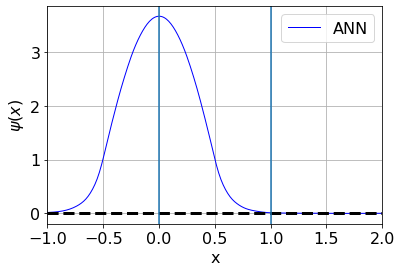

In [14]:
tru = np.sin(3*np.pi*t_net)*np.max(-1*psi)
#plt.plot(t_net, tru, '-r', linewidth = 1, label = 'True')
plt.xlim(-1,2)
plt.plot(t_net, 1*psi, '-b', linewidth=1, label = 'ANN')
plt.legend()
plt.plot(t_net, np.zeros(len(t_net)),'--k', linewidth=3)
plt.xlabel('x')
plt.ylabel('$\psi(x)$')
plt.grid('on')
plt.axvline(x = 0)
plt.axvline(x = 1)


tensor(3.3786, grad_fn=<SelectBackward>)

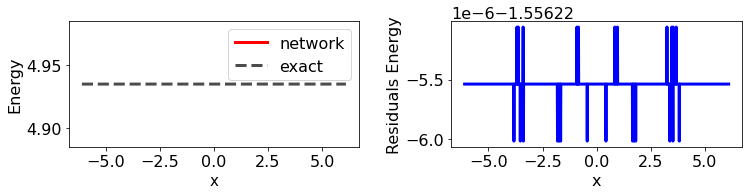

In [15]:
E1 = np.pi**2/2 # ground
p,e=model1(tTest)
#ed = dfx(tTest,e)

plt.figure(figsize=[16,3])
### 
plt.subplot(1,3,1)
plt.plot(t_net, e.data.numpy(), '-r', label='network', linewidth=3)
plt.plot(t_net, E1*t_net/t_net, '--k', label='exact', linewidth=3, alpha=0.7)
plt.ylim([0.99*E1, 1.01*E1])

plt.legend()
plt.xlabel('x',fontsize=15)
plt.ylabel('Energy')
###

plt.subplot(1,3,2)
plt.plot(t_net, e.data.numpy()-E1*t_net/t_net, '-b', linewidth=3)
# plt.ylim([-1e-3, 1e-3])
plt.xlabel('x')
plt.ylabel('Residuals Energy')

#plt.subplot(1,3,3)
#plt.plot(t_net, ed.data.numpy(),'b', linewidth=3)
#plt.xlabel('x')
#plt.ylabel('d/dx Energy')

plt.tight_layout()
e[0][0]

Text(0.5, 6.300000000000001, 't')

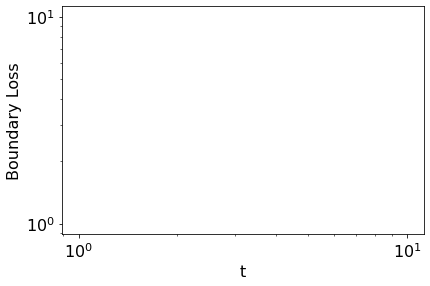

In [ ]:
#(Loss_history, boundary_loss_history, nontriv_loss_history, SE_loss_history, Ennontriv_loss_history)
plt.loglog(loss_hists1[1],'-b',alpha=0.975);
#plt.axvline(x = aarg)

plt.tight_layout()
plt.ylabel('Boundary Loss');plt.xlabel('t')

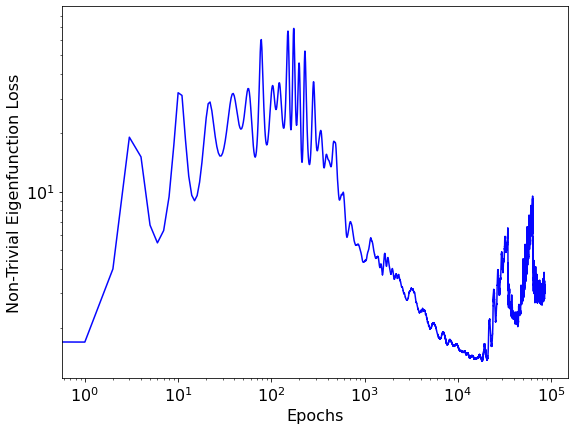

In [16]:
#(Loss_history, boundary_loss_history, nontriv_loss_history, SE_loss_history, Ennontriv_loss_history)
plt.figure(figsize =(8,6))
plt.loglog(loss_hists1[2],'-b',alpha=0.975);
#plt.axvline(x = aarg)

plt.tight_layout()
plt.ylabel('Non-Trivial Eigenfunction Loss');plt.xlabel('Epochs')
plt.savefig(imgdir+'finite_nontrivfunc_loss.png', bbox_inches = 'tight')

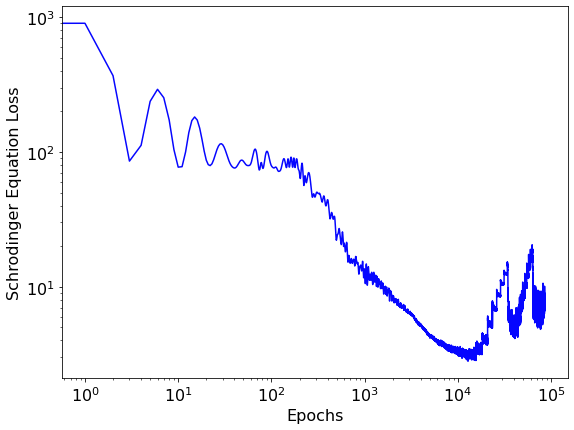

In [17]:
#(Loss_history, boundary_loss_history, nontriv_loss_history, SE_loss_history, Ennontriv_loss_history)
plt.figure(figsize =(8,6))

plt.loglog(loss_hists1[3],'-b',alpha=0.975);
#plt.axvline(x = aarg)

plt.tight_layout()
plt.ylabel('Schrodinger Equation Loss');plt.xlabel('Epochs')
plt.savefig(imgdir+'finite_SE_loss.png', bbox_inches = 'tight')

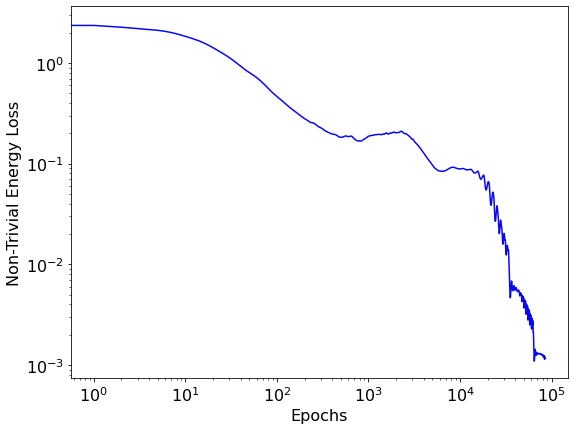

In [18]:
#(Loss_history, boundary_loss_history, nontriv_loss_history, SE_loss_history, Ennontriv_loss_history)
plt.figure(figsize =(8,6))

plt.loglog(loss_hists1[4],'-b',alpha=0.975);
#plt.axvline(x = aarg)

plt.tight_layout()
plt.ylabel('Non-Trivial Energy Loss');plt.xlabel('Epochs')
plt.savefig(imgdir+'finite_nontrivE_loss.png', bbox_inches = 'tight')

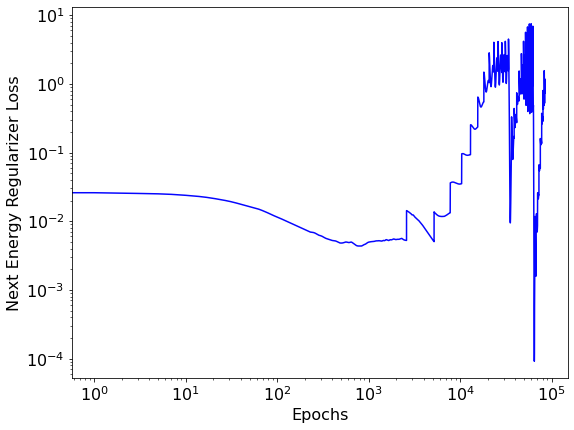

In [19]:
#(Loss_history, boundary_loss_history, nontriv_loss_history, SE_loss_history, Ennontriv_loss_history)
plt.figure(figsize =(8,6))

plt.loglog(loss_hists1[5],'-b',alpha=0.975);
#plt.axvline(x = aarg)

plt.tight_layout()
plt.ylabel('Next Energy Regularizer Loss');plt.xlabel('Epochs')
plt.savefig(imgdir+'finite_nextE_loss.png', bbox_inches = 'tight')

Text(0.5, 6.300000000000001, 't')

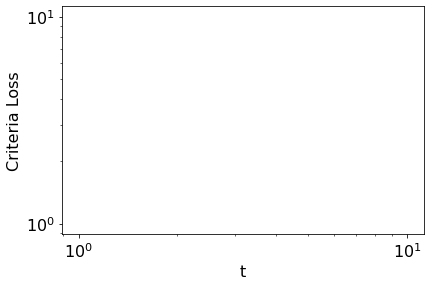

In [ ]:
#(Loss_history, boundary_loss_history, nontriv_loss_history, SE_loss_history, Ennontriv_loss_history)
plt.loglog(loss_hists1[6],'-b',alpha=0.975);
#plt.axvline(x = np.argmin(loss_hists1[6]))
plt.tight_layout()
plt.ylabel('Criteria Loss');plt.xlabel('t')

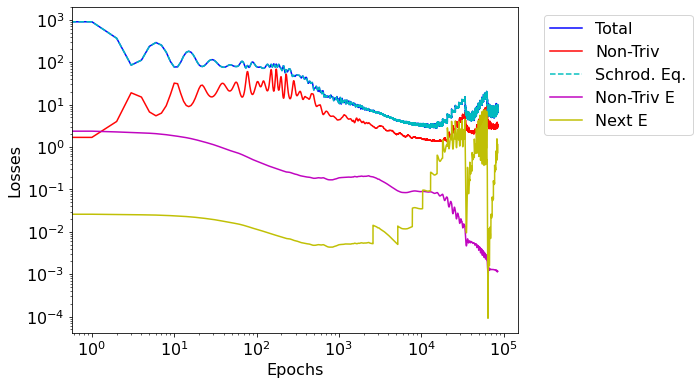

In [20]:
# Loss_history, boundary_loss_history, nontriv_loss_history, SE_loss_history, Ennontriv_loss_history, En_loss_history
plt.figure(figsize =(8,6))

plt.loglog(loss_hists1[0],'-b',alpha=0.975, label = 'Total');
#plt.loglog(loss_hists1[1],'-g',alpha=0.975, label = 'Boundary');
plt.loglog(loss_hists1[2],'-r',alpha=0.975, label = 'Non-Triv');
plt.loglog(loss_hists1[3],'--c',alpha=0.975, label = 'Schrod. Eq.');
plt.loglog(loss_hists1[4],'-m',alpha=0.975, label = 'Non-Triv E');
plt.loglog(loss_hists1[5],'-y',alpha=0.975, label = 'Next E');
#plt.loglog(loss_hists1[6],'-k',alpha=0.975, label = 'Criteria');
#plt.axvline(x = aarg)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.ylabel('Losses'); plt.xlabel('Epochs')
plt.savefig(imgdir+'finite_all_loss.png', bbox_inches = 'tight')

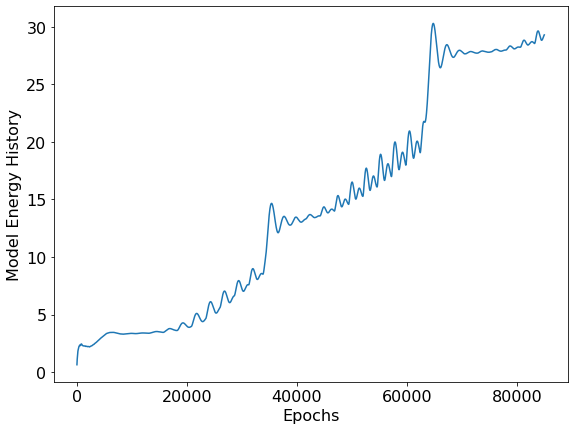

In [21]:
plt.figure(figsize = (8,6))
plt.plot(loss_hists1[8])
#plt.axvline(x = aarg)
plt.tight_layout()
plt.ylabel('Model Energy History');plt.xlabel('Epochs')
plt.savefig(imgdir+'finite_modelE_hist.png', bbox_inches = 'tight')

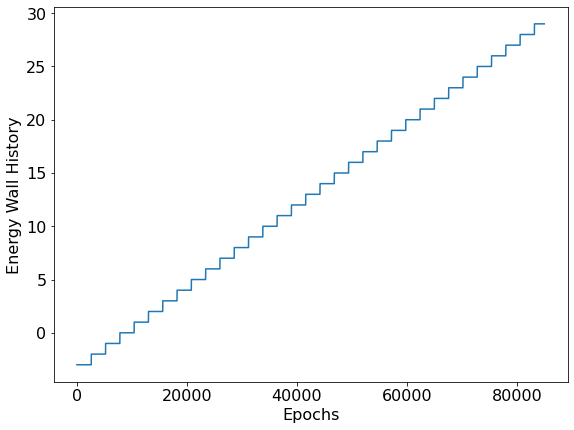

In [22]:
plt.figure(figsize = (8,6))
plt.plot(loss_hists1[9])
#plt.axvline(x = aarg)
plt.tight_layout()
plt.ylabel('Energy Wall History');plt.xlabel('Epochs')
plt.savefig(imgdir+'finite_Ewall_hist.png', bbox_inches = 'tight')

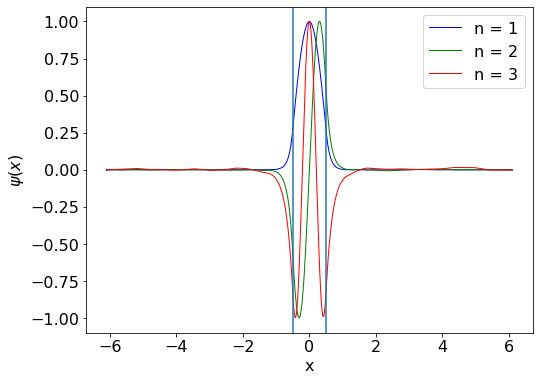

In [ ]:

psi_0to10 = parametricSolutions(tTest,loss_hists1[10][0][0],t0,xBC1)
psi_10to20 = parametricSolutions(tTest,loss_hists1[10][1][0],t0,xBC1)
psi_20to30 = parametricSolutions(tTest,loss_hists1[10][2][0],t0,xBC1)
#psi_30to40 = parametricSolutions(tTest,loss_hists1[10][3][0],t0,xBC1)

plt.figure(figsize = (8,6))
plt.plot(t_net, -1*psi_0to10.data.numpy()/np.max(np.abs(psi_0to10.data.numpy())), '-b', linewidth=1, label = 'n = 1')
plt.plot(t_net, 1*psi_10to20.data.numpy()/np.max(np.abs(psi_10to20.data.numpy())), '-g', linewidth=1, label = 'n = 2')
plt.plot(t_net, 1*psi_20to30.data.numpy()/np.max(np.abs(psi_20to30.data.numpy())), '-r', linewidth=1, label = 'n = 3')
plt.legend()
plt.axvline(x = -0.5)
plt.axvline(x = 0.5)

#plt.plot(t_net, 1*psi_30to40.data.numpy(), '-b', linewidth=1, label = 'ANN')
plt.ylabel('$\psi(x)$'); plt.xlabel('x')
plt.savefig(imgdir+'finite_eigenfuncs2.png', bbox_inches = 'tight')

In [ ]:
print(loss_hists1[10][0][0].forward(tTest)[1][0])
print(loss_hists1[10][1][0].forward(tTest)[1][0])
print(loss_hists1[10][2][0].forward(tTest)[1][2])
#print(loss_hists1[10][3][0].forward(tTest)[1][4])
# True eigenvalues are 3.279, 12.884, 27.783
# for E = 3.279, k = 2.561, alpha = 8.570
# for E = 12.884, k = 5.076, alpha = 7.364
# for E = 27.783, k = , alpha = 

tensor([3.3769], grad_fn=<SelectBackward>)
tensor([13.2627], grad_fn=<SelectBackward>)
tensor([27.7770], grad_fn=<SelectBackward>)


# Error Analysis

## Ground State

In [ ]:
I = tTest.data.numpy()# last element in Region 1
II = tTest.data.numpy()[551:649] # Region 2
III = tTest.data.numpy()[649:] # First element in Region 3
all = tTest.data.numpy()


In [ ]:
#tru = np.sin(3*np.pi*t_net)*np.max(-1*psi)
#plt.plot(t_net, tru, '-r', linewidth = 1, label = 'True')
#plt.xlim(-1,2)
#plt.plot(t_net, 1*psi, '-b', linewidth=1, label = 'ANN')
B = 1
A = B*0.28624/0.013774
truII = B*np.cos(2.561*tTest.data.numpy()[551:649])
truI = A*np.exp(8.57*tTest.data.numpy()[:551])
truIII = A*np.exp(-8.57*tTest.data.numpy()[649:])


Mean Squared Error: 1.0226947


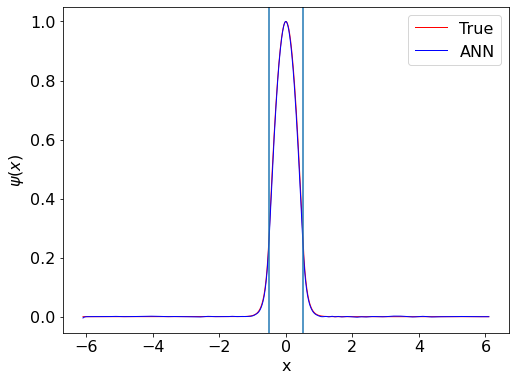

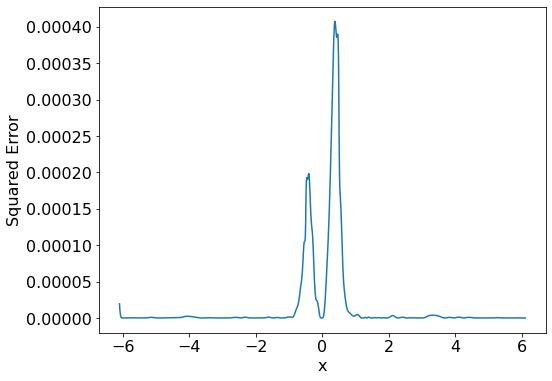

In [ ]:
plt.figure(figsize = (8,6))
trusol = np.concatenate((truI, 1*truII, truIII), axis = 0)
plt.plot(all, trusol, '-r', linewidth = 1, label = 'True')
#plt.plot(II, truII, '-r', linewidth = 1, label = 'True')
plt.plot(t_net, -1*psi_0to10.data.numpy()/np.max(np.abs(psi_0to10.data.numpy())), '-b', linewidth=1, label = 'ANN')
plt.legend()
plt.axvline(x = -0.5)
plt.axvline(x = 0.5)
plt.ylabel('$\psi(x)$'); plt.xlabel('x')
plt.savefig(imgdir+'finite_ground.png', bbox_inches = 'tight')

plt.figure(figsize = (8,6))
plt.plot(all, (trusol-(-1*psi_0to10.data.numpy()/np.max(np.abs(psi_0to10.data.numpy()))))**2)
plt.ylabel('Squared Error');plt.xlabel('x')
print('Mean Squared Error: ' + str(np.mean(np.square(trusol-psi_0to10.data.numpy()))))
plt.savefig(imgdir+'finite_ground_err.png', bbox_inches = 'tight')

## First Excited State

In [ ]:
# for E = 12.884, 
k = 5.076; alpha = 7.364

B = 1
A = B*-0.5676/0.025173
truII = B*np.sin(k*tTest.data.numpy()[551:649])
truI = A*np.exp(alpha*tTest.data.numpy()[:551])
truIII = -A*np.exp(-alpha*tTest.data.numpy()[649:])

Mean Squared Error: 0.19870225


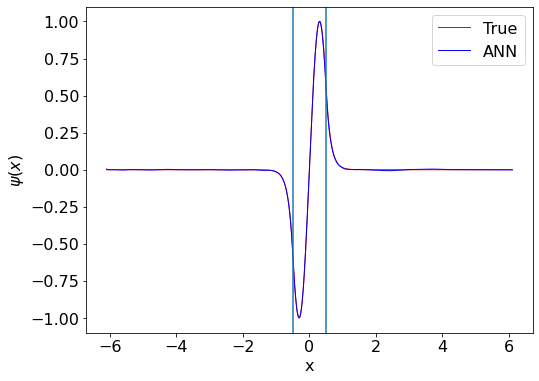

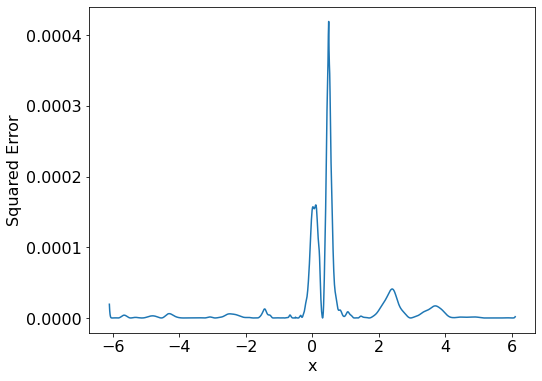

In [ ]:
plt.figure(figsize = (8,6))

trusol = np.concatenate((truI, truII, truIII), axis = 0)
plt.plot(all, trusol, '-r', linewidth = 1, label = 'True')
#plt.plot(II, truII, '-r', linewidth = 1, label = 'True')
plt.plot(t_net, 1*psi_10to20.data.numpy()/np.max(np.abs(psi_10to20.data.numpy())), '-b', linewidth=1, label = 'ANN')
plt.legend()
plt.axvline(x = -0.5)
plt.axvline(x = 0.5)
plt.ylabel('$\psi(x)$'); plt.xlabel('x')
plt.savefig(imgdir+'finite_first.png', bbox_inches = 'tight')


plt.figure(figsize = (8,6))
plt.plot(all, (trusol-(1*psi_10to20.data.numpy()/np.max(np.abs(psi_10to20.data.numpy()))))**2)
plt.ylabel('Squared Error');plt.xlabel('x')
print('Mean Squared Error: ' + str(np.mean(np.square(trusol-psi_10to20.data.numpy()))))
plt.savefig(imgdir+'finite_first_err.png', bbox_inches = 'tight')

## 2nd Excited State

In [ ]:
# for E = 27.783, 
k = 7.4543; alpha = 4.9431


B = 1
A = B*-0.8334/0.084454
truII = B*np.cos(k*tTest.data.numpy()[551:649])
truI = A*np.exp(alpha*tTest.data.numpy()[:551])
truIII = A*np.exp(-alpha*tTest.data.numpy()[649:])

Mean Squared Error: 0.675882


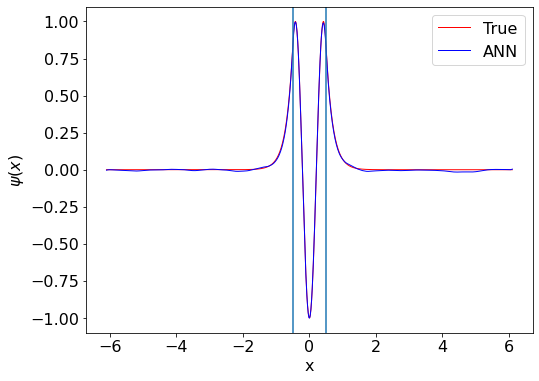

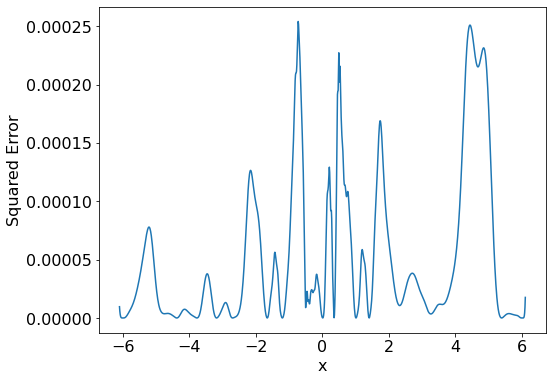

In [ ]:
plt.figure(figsize = (8,6))

trusol = -1*np.concatenate((truI, truII, truIII), axis = 0)
plt.plot(all, trusol, '-r', linewidth = 1, label = 'True')
#plt.plot(II, truII, '-r', linewidth = 1, label = 'True')
plt.plot(t_net, -1*psi_20to30.data.numpy()/np.max(np.abs(psi_20to30.data.numpy())), '-b', linewidth=1, label = 'ANN')
plt.legend()
plt.axvline(x = -0.5)
plt.axvline(x = 0.5)
plt.ylabel('$\psi(x)$'); plt.xlabel('x')
plt.savefig(imgdir+'finite_second.png', bbox_inches = 'tight')


plt.figure(figsize = (8,6))
plt.plot(all, (trusol-(-1*psi_20to30.data.numpy()/np.max(np.abs(psi_20to30.data.numpy()))))**2)
plt.ylabel('Squared Error');plt.xlabel('x')
print('Mean Squared Error: ' + str(np.mean(np.square(trusol-psi_20to30.data.numpy()))))
plt.savefig(imgdir+'finite_second_err.png', bbox_inches = 'tight')

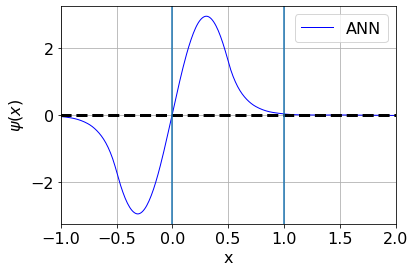

In [ ]:
psi =parametricSolutions(tTest,loss_hists1[10][1][0],t0,xBC1) 
psi=psi.data.numpy(); 

plt.xlim(-1,2)
plt.plot(t_net, 1*psi, '-b', linewidth=1, label = 'ANN')
plt.legend()
plt.plot(t_net, np.zeros(len(t_net)),'--k', linewidth=3)
plt.xlabel('x')
plt.ylabel('$\psi(x)$')
plt.grid('on')
plt.axvline(x = 0)
plt.axvline(x = 1)